`Albert Tadros
CSc_447
Final Project_ Building and Training CNN
'

## Function to visualize the piano chords. This visualization will be used when making a prediction using the trained model 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from scipy import signal
from IPython.display import Audio, Image
import librosa
import librosa.display
import pylab
from numpy.fft import fft, ifft
%matplotlib inline
import math
from PIL import Image, ImageDraw

# Load the triad csv file, to get chord names and notes 
triads = pd.read_csv("triads.csv")
triads.head(20)

df = pd.DataFrame(triads)
df.shape

def make_keyboard(chord):
    key_width = 15
    key_height = 100
    octaves = 7
    
    white_keys = ["C","D","E","F","G","A","B"]
    black_keys = ['Cs',"Eb","Fs","Gs","Bb"]
    
    notes2 = []
    notes2.append([str(chord['Note1'].values[0]).split("_")[0], str(chord['Note1'].values[0]).split("_")[1]])
    notes2.append([str(chord['Note2'].values[0]).split("_")[0], str(chord['Note2'].values[0]).split("_")[1]])
    notes2.append([str(chord['Note3'].values[0]).split("_")[0], str(chord['Note3'].values[0]).split("_")[1]])
    
    img_width = (key_width) * 7 * (octaves + 1)
    img_height = key_height + 5

    img = Image.new("RGB", (img_width, img_height), color=(230,230,230))
    img1 = ImageDraw.Draw(img)

    # Draw the white keys
    for i in range(2, octaves + 2):
        offset = (i * (key_width + 2) * 7) - ((key_width + 2) * 7 * 2)
        
        # Draw the white keys
        j = 1
        for note in white_keys:
            fill_color = "FFFFFF"
            if (note == notes2[0][0] and str(i) == notes2[0][1]) or (note == notes2[1][0] and str(i) == notes2[1][1]) or (note == notes2[2][0] and str(i) == notes2[2][1]):
                fill_color = "FF0000"
            x = j * (key_width + 2) + offset - key_width
            w = j * (key_width + 2) + key_width + offset - key_width
            img1.rectangle([(x, 0), (w, key_height)], fill = "#" + fill_color, outline ="#555555")
            j += 1

    # Draw the black keys
    for i in range(2, octaves + 2):
        offset = (i * (key_width + 2) * 7) - ((key_width + 2) * 7 * 2)
        j = 1
        for note in black_keys:
            fill_color = "444444"
            if (note == notes2[0][0] and str(i) == notes2[0][1]) or (note == notes2[1][0] and str(i) == notes2[1][1]) or (note == notes2[2][0] and str(i) == notes2[2][1]):
                fill_color = "FF0000"

            if (j == 3):
                j += 1   
            x = j * (key_width + 2) + offset - key_width + (key_width / 2) + 4
            w = j * (key_width + 2) + key_width + offset - key_width  + (key_width / 2)
            img1.rectangle([(x , 0), (w, key_height * .65)], fill = "#" + fill_color, outline = "#555555")
                
            j += 1

    display(img)

In [2]:
#df[df.Chord=="B_maj_2_1"]

# Building and Training the CNN Model

In [3]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

### Loading the processed audio data from the JSON file

In [4]:
# defining the path to the processed audio data
DATA_PATH = "../Final Project/audio_data_prepared.json"

def read_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mel"])        # array with mel_spectrogram values of audio segments processed
    y = np.array(data["labels"])     # array labels of each mel_spectrogrammed audio segement
    maps = np.array(data["chordnames"]) # array of chord names
    return X, y, maps

In [5]:
def plot_evaluation(history):

    fig, axs = plt.subplots(2, figsize=(10,10))
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

    # plot accuracy 
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # plot error
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error evaluation")

    plt.show()

In [6]:
# Load data and split it into train, validation and test sets

def data_Prep(test_size, validation_size):
    
    # test_size is a value in the range [0, 1] which is the percentage of the data set to allocate to the test split
    # validation_size is a value in the range [0, 1] which is the percentage of the train set that should be allocated to validation split

    # load data 
    X, y, maps = read_data(DATA_PATH) # calling the load data function to get the processed audio data

    # split data into train, validation and test
        # X_train : Input training set
        # X_validation: Input validation set
        # X_test: Input test set
        # y_train: Target training set
        # y_validation: Target validation set
        # y_test (ndarray): Target test set
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, maps

### Building the CNN model

In [7]:
def create_model(input_shape):

    #create model
    model = keras.Sequential()

#add model layers
    
    # first conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # second conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # third conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feeding it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(360, activation='softmax'))

    return model

### Creating the prediction function

In [8]:
def predict(model, X, y, maps):

    #  model.predict() requires a 4d array. So, One more dimension to input data needs to be added.
    X = X[np.newaxis, ...]
    
    # run the prediction function
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))
  
    print("Target is {}: , Predicted label is {}".format(maps[y], maps[predicted_index]))
    
    return maps[y], maps[predicted_index] # returining Target chord and the Predicted Chord 

### Compiling the model

In [9]:
if __name__ == "__main__":

    # obtain train, validation, test sets
    X_train, X_validation, X_test, y_train, y_validation, y_test, maps = data_Prep(0.25, 0.2)

    # construct the CNN
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = create_model(input_shape)

    #compile model using accuracy to measure model performance
    optimiser = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimiser,loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

2021-12-20 22:24:10.117583: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-20 22:24:10.117990: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 32)         4

# Training the model, performing testing and prediction

Train on 2160 samples, validate on 540 samples
Epoch 1/30
2160/2160 [==============================] - 5s 2ms/sample - loss: 5.8697 - accuracy: 0.0083 - val_loss: 5.8927 - val_accuracy: 0.0074
Epoch 2/30
2160/2160 [==============================] - 3s 1ms/sample - loss: 5.2053 - accuracy: 0.0463 - val_loss: 5.9603 - val_accuracy: 0.0093
Epoch 3/30
2160/2160 [==============================] - 2s 1ms/sample - loss: 4.1601 - accuracy: 0.1491 - val_loss: 5.9227 - val_accuracy: 0.0074
Epoch 4/30
2160/2160 [==============================] - 3s 1ms/sample - loss: 3.0862 - accuracy: 0.3407 - val_loss: 5.8574 - val_accuracy: 0.0185
Epoch 5/30
2160/2160 [==============================] - 3s 1ms/sample - loss: 2.3660 - accuracy: 0.4579 - val_loss: 5.1850 - val_accuracy: 0.0722
Epoch 6/30
2160/2160 [==============================] - 3s 1ms/sample - loss: 1.7997 - accuracy: 0.5722 - val_loss: 4.1079 - val_accuracy: 0.2407
Epoch 7/30
2160/2160 [==============================] - 3s 1ms/sample - loss:

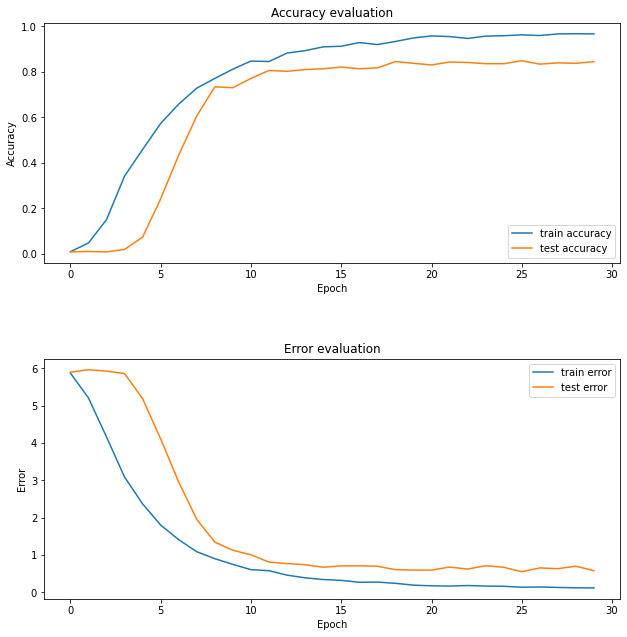

900/1 - 0s - loss: 0.4136 - accuracy: 0.8333

Test accuracy: 0.8333333
Target: 207, Predicted label: [207]
Target is Bb_dim_5_0: , Predicted label is ['Bb_dim_5_0']


In [10]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

# plotting accuracy and error for training and validation
plot_evaluation(history)

# using test set, evaluate model 
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# choosing a sample to predict from the test set
X_to_predict = X_test[50]
y_to_predict = y_test[50]

# run the sample prediction
filename1, filename2 = predict(model, X_to_predict, y_to_predict, maps)
chord1 = triads[triads['Chord'] == filename1]
chord2 = triads[triads['Chord'] == filename2[0]]

### Visualizing Target Sample Vs Predicted Sample

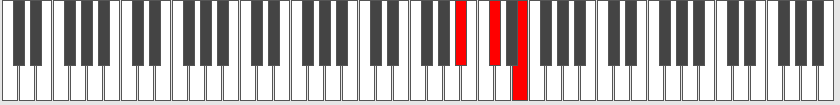

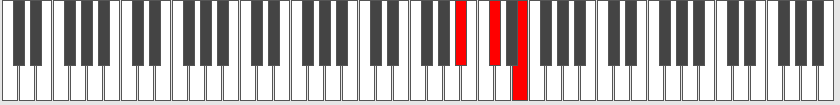

In [12]:
make_keyboard(chord1) # Target. First piano image
make_keyboard(chord2) # Predicted. second piano image